In [11]:
# Data manipulation library
import pandas as pd
import os
import numpy as np

from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [12]:
# Load Dataset
cat_folder = 'PetImages/Cat'  
dog_folder = 'PetImages/Dog'  

In [17]:
# Mengumpulkan gambar dengan format jpg dan png
cat_images = [os.path.join(cat_folder, f) for f in os.listdir(cat_folder) if f.endswith(('jpg', 'png'))]
dog_images = [os.path.join(dog_folder, f) for f in os.listdir(dog_folder) if f.endswith(('jpg', 'png'))]

In [19]:
# membuat label
cat_labels = ['cat'] * len(cat_images)
dog_labels = ['dog'] * len(dog_images)

In [21]:
# Menggabungkan label dan path gambar ke dalam dataframe
image_paths = cat_images + dog_images
labels = cat_labels + dog_labels

In [23]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [25]:
print(df)

                   image_path label
0         PetImages/Cat\0.jpg   cat
1         PetImages/Cat\1.jpg   cat
2        PetImages/Cat\10.jpg   cat
3       PetImages/Cat\100.jpg   cat
4      PetImages/Cat\1000.jpg   cat
...                       ...   ...
24993  PetImages/Dog\9995.jpg   dog
24994  PetImages/Dog\9996.jpg   dog
24995  PetImages/Dog\9997.jpg   dog
24996  PetImages/Dog\9998.jpg   dog
24997  PetImages/Dog\9999.jpg   dog

[24998 rows x 2 columns]


In [27]:
print(f"Jumlah gambar CAT: {len(cat_images)}")
print(f"Jumlah gambar DOG: {len(dog_images)}")

Jumlah gambar CAT: 12499
Jumlah gambar DOG: 12499


# Data Split

In [10]:
import os
import shutil
import random

# Path ke direktori utama
source_dir = 'PetImages'

# Path ke direktori train dan validation
train_dir = 'PetImages/train'
validation_dir = 'PetImages/validation'

# Membuat folder 'train' dan 'validation' jika belum ada
os.makedirs(os.path.join(train_dir, 'CAT'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'DOG'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'CAT'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'DOG'), exist_ok=True)

# Folder data untuk CAT dan DOG
cat_dir = os.path.join(source_dir, 'CAT')
dog_dir = os.path.join(source_dir, 'DOG')

# Fungsi untuk membagi gambar
def split_data(source_folder, train_folder, validation_folder, validation_ratio=0.2):
    # Mendapatkan daftar file gambar
    files = os.listdir(source_folder)
    
    # Mengacak urutan file
    random.shuffle(files)
    
    # Menghitung jumlah gambar untuk validasi
    num_validation = int(len(files) * validation_ratio)
    
    # Membagi file menjadi training dan validation
    validation_files = files[:num_validation]
    train_files = files[num_validation:]
    
    # Memindahkan gambar ke folder yang sesuai
    for file in train_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(train_folder, file))
    
    for file in validation_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(validation_folder, file))

# Membagi data untuk folder CAT
split_data(cat_dir, os.path.join(train_dir, 'CAT'), os.path.join(validation_dir, 'CAT'))

# Membagi data untuk folder DOG
split_data(dog_dir, os.path.join(train_dir, 'DOG'), os.path.join(validation_dir, 'DOG'))

print("Data telah dibagi menjadi train dan validation.")


Data telah dibagi menjadi train dan validation.


# Preprocessing

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
)

# Tanpa augmentasi untuk data validasi
validation_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi saja untuk data validasi

# Membaca data pelatihan dari folder 'train'
train_generator = train_datagen.flow_from_directory(
    'PetImages/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    'PetImages/validation',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 24794 images belonging to 2 classes.
Found 9756 images belonging to 2 classes.


## Ploting 

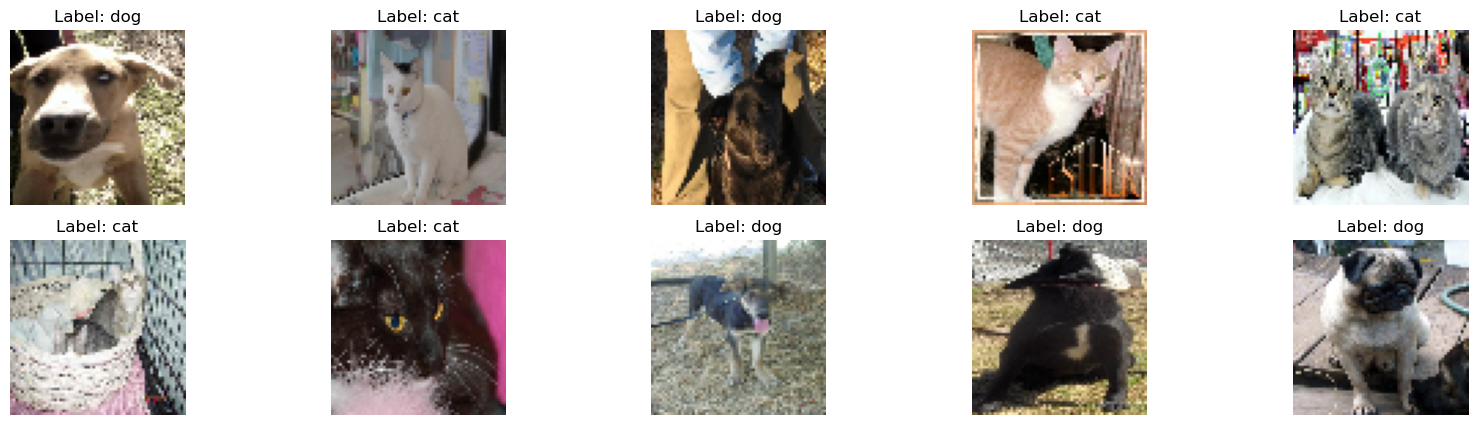

In [34]:

batch = next(train_generator)  # Mengambil satu batch
images = batch[0]  # Gambar dalam batch
labels = batch[1]  # Label dalam batch

# Menampilkan beberapa gambar dalam batch
fig, axes = plt.subplots(2, 5, figsize=(20, 5))  # 1 baris dan 10 kolom

for i, ax in enumerate(axes.flat):
    # Menampilkan gambar
    ax.imshow(images[i])  # Menampilkan gambar yang sudah diproses
    label = 'dog' if labels[i] == 1 else 'cat'  # Mengonversi label numerik menjadi string
    ax.set_title(f"Label: {label}")  # Menampilkan label di atas gambar
    ax.axis('off')  # Menyembunyikan axis

plt.show()


# Modelling

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Membangun model CNN
model = Sequential()

# Menambahkan layer Input (dimensi input diatur dengan jelas)
model.add(Input(shape=(64, 64, 3)))  # Dimensi input diatur menggunakan Input layer

# Menambahkan lapisan Conv2D, MaxPooling2D, Flatten, dan Dense
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Menambahkan dropout untuk mengurangi overfitting
model.add(Dense(1, activation='sigmoid'))  # Klasifikasi biner

optimizer = Adam(learning_rate=0.01)
# Menyusun model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [63]:
history = model.fit(
    train_generator,
    steps_per_epoch=20,  # Lebih sedikit dari jumlah batch total
    epochs=100,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=1
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.5263 - loss: 0.7254 - val_accuracy: 0.5344 - val_loss: 0.6803
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.5277 - loss: 0.6933 - val_accuracy: 0.5813 - val_loss: 0.6905
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 397ms/step - accuracy: 0.5170 - loss: 0.6917 - val_accuracy: 0.6219 - val_loss: 0.6855
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.5631 - loss: 0.6861 - val_accuracy: 0.5094 - val_loss: 0.6998
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.5725 - loss: 0.6808 - val_accuracy: 0.5250 - val_loss: 0.6738
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.5970 - loss: 0.6700 - val_accuracy: 0.6562 - val_loss: 0.6539
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.6432 - loss: 0.6565 - val_accuracy: 0.6219 - val_loss: 0.6583
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.6511 - loss: 0.6454 - val_acc

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7907 - loss: 0.4829 - val_accuracy: 0.7750 - val_loss: 0.4588
Epoch 40/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.7422 - loss: 0.5037 - val_accuracy: 0.7719 - val_loss: 0.4781
Epoch 41/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.7572 - loss: 0.4880 - val_accuracy: 0.8313 - val_loss: 0.4009
Epoch 42/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7704 - loss: 0.4845

C:\Users\ASUS\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.7697 - loss: 0.4853 - val_accuracy: 0.7844 - val_loss: 0.4838
Epoch 43/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.7732 - loss: 0.5090 - val_accuracy: 0.8000 - val_loss: 0.4357
Epoch 44/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.7497 - loss: 0.4980 - val_accuracy: 0.8031 - val_loss: 0.4468
Epoch 45/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.8144 - loss: 0.4152 - val_accuracy: 0.7625 - val_loss: 0.5136
Epoch 46/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.8008 - loss: 0.4795 - val_accuracy: 0.8125 - val_loss: 0.4711
Epoch 47/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.7728 - loss: 0.5155 - val_accuracy: 0.8313 - val_loss: 0.4262
Epoch 48/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.7745 - loss: 0.4662 - val_accuracy: 0.7969 - val_loss: 0.4566
Epoch 49/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.8028 - loss: 0.3996 - val_accuracy:

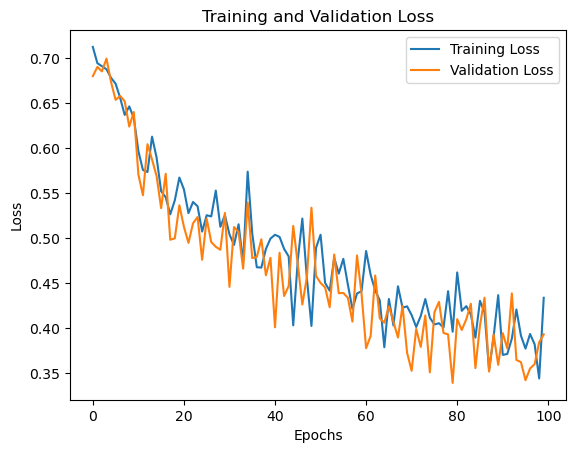

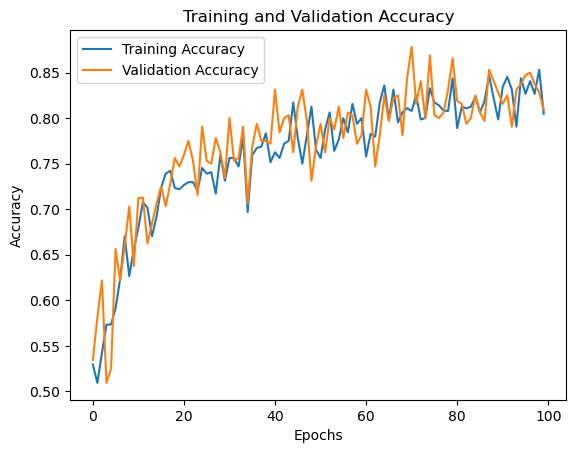

In [65]:
import matplotlib.pyplot as plt

# Plot the training and validation loss or accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# You can also plot accuracy if you prefer
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Evaluasi

In [67]:
# Evaluasi model pada data validasi
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


381/381 ━━━━━━━━━━━━━━━━━━━━ 71s 186ms/step - accuracy: 0.8350 - loss: 0.3719
Validation Loss: 0.37232840061187744
Validation Accuracy: 0.8385006785392761


## Membuat folder test

In [73]:
import os
import shutil
import random

# Paths to your existing folders
source_validation_dir = 'PetImages/validation'
test_dir = 'PetImages/test'

# Create the new test directory (if it doesn't exist)
os.makedirs(test_dir, exist_ok=True)

# Create subfolders for 'cat' and 'dog' in the 'test' directory
os.makedirs(os.path.join(test_dir, 'CAT'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'DOG'), exist_ok=True)

# Function to split data into train, validation, and test
def split_data(source_folder, destination_folder, split_ratio=0.2):
    # Loop through both 'CAT' and 'DOG' directories
    for class_name in os.listdir(source_folder):
        class_folder = os.path.join(source_folder, class_name)
        if os.path.isdir(class_folder):
            files = os.listdir(class_folder)
            random.shuffle(files)

            # Calculate the number of files to move to test folder
            num_test_files = int(len(files) * split_ratio)
            test_files = files[:num_test_files]

            # Move the selected files to the test folder
            for file in test_files:
                shutil.move(os.path.join(class_folder, file), os.path.join(destination_folder, class_name, file))

# Split data from validation folder to test folder
split_data(source_validation_dir, test_dir, split_ratio=0.2)

print("Data successfully split into test and validation.")


Data successfully split into test and validation.


In [78]:
# Assuming you have a 'test' folder similar to 'train' and 'validation'
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize image pixels

test_generator = test_datagen.flow_from_directory(
    'PetImages/test',  # Path to the 'test' directory
    target_size=(64, 64),  # Resize images to the same size as training images
    batch_size=32,  # Batch size for evaluation
    class_mode='binary',  # Use 'binary' if it's a binary classification task
)

# Evaluasi pada test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


Found 2438 images belonging to 2 classes.


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8566 - loss: 0.3424
Test Loss: 0.3445341885089874
Test Accuracy: 0.8589637875556946


# Test Prediksi

In [111]:
# Menggunakan model untuk prediksi gambar baru
from tensorflow.keras.preprocessing import image
import numpy as np

# Memuat gambar baru
img = image.load_img("D:\\alley-our-bnr.jpg", target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Mengubah dimensi gambar menjadi batch

# Melakukan prediksi
prediction = model.predict(img_array)
print(f"Prediksi: {'Cat' if prediction[0] < 0.5 else 'Dog'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi: Cat


In [113]:
img = image.load_img(r"C:\Users\ASUS\OneDrive\Pictures\Golden-Retriever.png", 
                     target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print(f"Prediksi: {'Cat' if prediction[0] < 0.5 else 'Dog'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediksi: Dog
